# Reactor Kinetics Example for Pyomo.DoE Tutorial

**Prepared by:** Jialu Wang (jwang44@nd.edu), Prof. Alexander Dowling (adowling@nd.edu), [Hailey Lynch](https://github.com/hglynch) (hlynch@nd.edu, 2023)
    

## Introduction and Learning Objectives

This notebook uses **design of experiments** for a reactor kinetics experiment with Pyomo.DoE. The user will be able to learn concepts involved in Model-Based Design of Experiments (MBDoE) and practice using Pyomo.DoE from methodology in the notebook. Results will be interpreted throughout the notebook to connect the material with the Pyomo implementation.

The general process we will follow throughout this notebook:
* Import Modules
    * Step 0: Import Pyomo and Pyomo.DoE Module
* Problem Statement
    * Step 1: Mathematical Model for the Reaction Kinetics Example
* Implementation in Pyomo
    * Step 2: Implement Mathematical Model
    * Step 3: Define Inputs for the Model
    * Step 4: Generate an Experiment
* Methodology
    * Step 5: Method for Computing FIM 
    * Step 6: Method for Optimization
    * Step 7: Method for Exploratory Analysis through Enumeration 
* Visualizing Results
    * Step 8: Results through Heatmaps and Sensitivity Curves 
* Key Takeaways

## Import Modules

## Step 0: Import Pyomo and Pyomo.DoE Module

In [1]:
# IPOPT installer
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()

--2023-05-05 03:37:40--  https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7171 (7.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   7.00K  --.-KB/s    in 0s      

2023-05-05 03:37:41 (63.7 MB/s) - ‘helper.py’ saved [7171/7171]

Installing idaes via pip...
idaes was successfully installed
Running idaes get-extensions to install Ipopt, k_aug, and more...
Ipopt 3.13.2 (x86_64-pc-linux-gnu), ASL(20190605)

[K_AUG] 0.1.0, Part of the IDAES PSE framework
Please visit https://idaes.org/ (x86_64-pc-linux-gnu), ASL(20190605)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyomo.common.unittest as unittest
from pyomo.contrib.doe import DesignOfExperiments, Measurements
from pyomo.dae import ContinuousSet, DerivativeVar

## Problem Statement

## Step 1: Mathematical Model for the Reaction Kinetics Example

### Reaction Kinetics

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$:

$$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$$ 

**Goal:** 
* Design a large-scale continuous reactor that maximizes the production of $B$.
 <br>

The rate laws for these two chemical reactions are:

$$r_A = -k_1 C_A$$

$$r_B = k_1 C_A - k_2 C_B$$

$$r_C = k_2 C_B$$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. \\

The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$$k_1 = A_1 \exp \left({\frac{-1000 E_1}{R T}} \right)$$

$$k_2 = A_2 \exp \left({\frac{-1000 E_2}{R T}}\right)$$

where:
* $A_1$ [$s^{-1}$], $A_2$ [$s^{-1}$], $E_1$ [$kJ/mol$], and $E_2$ [$kJ/mol$] are fitted model parameters.
* $R$ [$J/mol K$] is the ideal-gas constant.
* $T$ [$K$] is absolute temperature.

**Objective:** 
* Using the Pyomo ecosystem, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale batch reactor to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch Reactor

The concentrations in a batch reactor evolve with time and are modeled by the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A(t) $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A(t) - k_2 C_B(t) $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B(t) $$

We have now established a linear system of differential equations. Next we can write our initial conditions where we assume the feed is only species $A$ such that:

$$C_A(t=0) = C_{A0}, \quad C_B(t=0) = 0, \quad C_C(t=0) = 0$$

When $k_1$ and $k_2$ are at constant temperature, we have the following analytic solution:

$$C_A(t) = C_{A0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A0} - \frac{k_2}{k_2 - k_1} C_{A0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A0} = C_{A0} - C_{A}(t) - C_{B}(t)$$

See the following for more information on batch reactors:
* Batch Reactor: [AIChE](https://www.aiche.org/ccps/resources/glossary/process-safety-glossary/batch-reactor-0#:~:text=A%20reactor%20in%20which%20the,the%20end%20of%20the%20batch) / [Wikipedia](https://en.wikipedia.org/wiki/Batch_reactor)

## Implementation in Pyomo

## Step 2: Implement Mathematical Model

This mathematical model is comprised of a system of dynamic algebraic equations (DAEs). This system will be solved using Pyomo.DAE.

See the following notebooks from CBE 60499 regarding Pyomo.DAE:
* [Dynamic Optimization Overview](https://ndcbe.github.io/optimization/notebooks/2/DAE-modeling.html)
* [Dynamic Optimization Example](https://ndcbe.github.io/optimization/notebooks/2/Pyomo-DAE.html)

First we will discretize using Pyomo.DAE.

In [3]:
# Function that discretizes using Pyomo.DAE
def disc_for_measure(m, NFE=32):
    '''
    Pyomo.DAE discretization

    Arguments:
    m: Pyomo model
    NFE: number of finite elements

    Return:
    m : Pyomo model
    '''
    # Discretization
    discretizer = pyo.TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=NFE, ncp=3, wrt=m.t)
    for z in m.scena:
        for t in m.t:
            m.dCdt_rule[z, 'CC', t].deactivate()
    return m


Next, we will create the model.

In [4]:
# Create model
def create_model(
    scena,
    const=False,
    control_time=None,
    control_val=None,
    t_range=[0.0, 1],
    CA_init=1,
    C_init=0.1,
    model_form='dae-index-1',
    args=[True],
):
    """
    This is an example user model provided to DoE library.
    It is a dynamic problem solved by Pyomo.DAE.

    Arguments:
    ---------
    scena: a dictionary of scenarios, achieved from scenario_generator()
    control_time: time-dependent design (control) variables, a list of control timepoints
    control_val: control design variable values T at corresponding timepoints
    t_range: time range, h
    CA_init: time-independent design (control) variable, an initial value for CA
    C_init: An initial value for C
    model_form: choose from 'ode-index-0' and 'dae-index-1'
    args: a list, deciding if the model is for k_aug or not. If [False], it is for k_aug, the parameters are defined as Var instead of Param.
    
    Return:
    ------
    m: a Pyomo.DAE model
    """
    # Parameter initialization, results from parameter estimation
    theta_pe = {
        'A1': 85,
        'A2': 370,
        'E1': 8,
        'E2': 15,
    }
    # Concentration initialization
    y_init = {'CA': CA_init, 'CB': 0.0, 'CC': 0.0}

    # Parameter list
    para_list = ['A1', 'A2', 'E1', 'E2']

    # Control time
    if not control_time:
        control_time = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

    # Control value
    if not control_val:
        control_val = [300] * 9

    # Controls
    controls = {}
    for i, t in enumerate(control_time):
        controls[t] = control_val[i]

    ### Add variables
    m = pyo.ConcreteModel()

    m.CA_init = CA_init
    m.para_list = para_list
    t_control = control_time

    m.scena_all = scena
    m.scena = pyo.Set(initialize=scena['scena-name'])

    # DAEs
    if model_form == 'ode-index-0':
        m.index1 = False
    elif model_form == 'dae-index-1':
        m.index1 = True
    else:
        raise ValueError('Please choose from "ode-index-0" and "dae-index-1"')

    # Timepoints
    m.t = ContinuousSet(bounds=(t_range[0], t_range[1]))

    # Control time points
    m.t_con = pyo.Set(initialize=t_control)

    # Set
    m.t0 = pyo.Set(initialize=[0])

    # Time-independent design variable
    m.CA0 = pyo.Var(
        m.t0, initialize=CA_init, bounds=(1.0, 5.0), within=pyo.NonNegativeReals
    )  # mol/L

    # Time-dependent design variable, initialized with the first control value
    def T_initial(m, t):
        if t in m.t_con:
            return controls[t]
        else:
            # count how many control points are before the current t;
            # locate the nearest neighbouring control point before this t
            j = -1
            for t_con in m.t_con:
                if t > t_con:
                    j += 1
            neighbour_t = t_control[j]
            return controls[neighbour_t]

    # Variable
    m.T = pyo.Var(
        m.t, initialize=T_initial, bounds=(300, 700), within=pyo.NonNegativeReals
    )

    # Gas constant
    m.R = 8.31446261815324  # J / K / mole

    # Define parameters as Param
    if args[0]:
        m.A1 = pyo.Param(m.scena, initialize=scena['A1'], mutable=True)
        m.A2 = pyo.Param(m.scena, initialize=scena['A2'], mutable=True)
        m.E1 = pyo.Param(m.scena, initialize=scena['E1'], mutable=True)
        m.E2 = pyo.Param(m.scena, initialize=scena['E2'], mutable=True)

    # If False, define parameters as Var (for k_aug)
    else:
        m.A1 = pyo.Var(m.scena, initialize=m.scena_all['A1'])
        m.A2 = pyo.Var(m.scena, initialize=m.scena_all['A2'])
        m.E1 = pyo.Var(m.scena, initialize=m.scena_all['E1'])
        m.E2 = pyo.Var(m.scena, initialize=m.scena_all['E2'])

    # Concentration variables under perturbation
    m.C_set = pyo.Set(initialize=['CA', 'CB', 'CC'])
    m.C = pyo.Var(m.scena, m.C_set, m.t, initialize=C_init, within=pyo.NonNegativeReals)

    # Time derivative of C
    m.dCdt = DerivativeVar(m.C, wrt=m.t)

    # Kinetic parameters
    def kp1_init(m, s, t):
        return m.A1[s] * pyo.exp(-m.E1[s] * 1000 / (m.R * m.T[t]))

    def kp2_init(m, s, t):
        return m.A2[s] * pyo.exp(-m.E2[s] * 1000 / (m.R * m.T[t]))

    m.kp1 = pyo.Var(m.scena, m.t, initialize=kp1_init)
    m.kp2 = pyo.Var(m.scena, m.t, initialize=kp2_init)

    def T_control(m, t):
        """
        T at interval timepoint equal to the T of the control time point at the beginning of this interval
        Count how many control points are before the current t;
        locate the nearest neighbouring control point before this t

        Arguments:
        m: model
        t: time

        Return:
        m: Pyomo model
        """
        if t in m.t_con:
            return pyo.Constraint.Skip
        else:
            j = -1
            for t_con in m.t_con:
                if t > t_con:
                    j += 1
            neighbour_t = t_control[j]
            return m.T[t] == m.T[neighbour_t]

    def cal_kp1(m, z, t):
        """
        Create the perturbation parameter sets

        Arguments:
        m: model
        z: scenario number
        t: time

        Return:
        m: Pyomo model
        """
        # LHS: 1/h
        # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
        return m.kp1[z, t] == m.A1[z] * pyo.exp(-m.E1[z] * 1000 / (m.R * m.T[t]))

    def cal_kp2(m, z, t):
        """
        Create the perturbation parameter sets

        Arguments:
        m: model
        z: m.pert, upper or normal or lower perturbation
        t: time

        Return:
        m: Pyomo model
        """
        # LHS: 1/h
        # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
        return m.kp2[z, t] == m.A2[z] * pyo.exp(-m.E2[z] * 1000 / (m.R * m.T[t]))

    def dCdt_control(m, z, y, t):
        """
        Calculate CA in Jacobian matrix analytically

        Arguments:
        z: scenario No.
        y: CA, CB, CC
        t: timepoints

        Return:
        m: Pyomo model
        """
        if y == 'CA':
            return m.dCdt[z, y, t] == -m.kp1[z, t] * m.C[z, 'CA', t]
        elif y == 'CB':
            return (
                m.dCdt[z, y, t]
                == m.kp1[z, t] * m.C[z, 'CA', t] - m.kp2[z, t] * m.C[z, 'CB', t]
            )
        elif y == 'CC':
            return m.dCdt[z, y, t] == m.kp2[z, t] * m.C[z, 'CB', t]

    def alge(m, z, t):
        """
        The algebraic equation for mole balance

        Arguments:
        z: m.pert
        t: time

        Return:
        m: Pyomo model
        """
        return m.C[z, 'CA', t] + m.C[z, 'CB', t] + m.C[z, 'CC', t] == m.CA0[0]

    # Control time
    m.T_rule = pyo.Constraint(m.t, rule=T_control)

    # Calculating C, Jacobian, FIM
    m.k1_pert_rule = pyo.Constraint(m.scena, m.t, rule=cal_kp1)
    m.k2_pert_rule = pyo.Constraint(m.scena, m.t, rule=cal_kp2)
    m.dCdt_rule = pyo.Constraint(m.scena, m.C_set, m.t, rule=dCdt_control)

    # Constraint for algebraic equation for mole balance
    m.alge_rule = pyo.Constraint(m.scena, m.t, rule=alge)

    # Boundary Conditions
    for z in m.scena:
        m.C[z, 'CB', 0.0].fix(0.0)
        m.C[z, 'CC', 0.0].fix(0.0)

    return m

## Step 3: Define Inputs for the Model

Since this model is a system of DAEs, we want to use MBDoE to optimize the experimental design variables called $\psi$ that consist of:
* Time-varying temperature control variables.
* Measurement response variables.
* Time points.

We will now define these inputs to optimize $\psi = (C_{A0}, T(t))$ for our model.

where $C_{A0}$ is the intial condition for species $A$ and $T(t)$ is the reactor temperature for varying time $t$.

In [5]:
# Create model
createmod = create_model

# Discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
# This is saying, what are the time points when the temperature can change 
# i.e., for a dynamic system, what variables do we need to manipulate the system around
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
# This is saying, at what specific time point are we going to make measurements 
# i.e., if the experiment lasts an hour, we have to figure out when we can take
# measurements during that hour
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# Design variable and its control time set
# i.e., design variables are being manipulated in the experiment 
dv_pass = {'CA0': [0],'T': t_control}
    
# Create measurement object
# This is saying, take measurements at the same time point for each species
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
measure_class =  Measurements(measure_pass)

# Define parameter nominal value 
parameter_dict = {'A1': 85, 'A2': 370, 'E1': 8, 'E2': 15}

## Step 4: Generate an Experiment

Recall the unknown model parameters, $\theta = (A_1, A_2, E_1, E_2)$.

Our goal is to **maximize** the precision of $\theta$ by measuring the model outputs called $y$ for the initial conditions at each time point such that $y(t)=(C_A(t), C_B(t), C_C(t))$.

Using our inputs, we will now define a function to generate an experiment to perform design of experiments. 

In [6]:
# Function to generate an experiment
def generate_exp(t_set, CA0, T):  
    """
    Generate experiments. 
    
    Arguments:
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 

    Return:
    dv_dict_overall: dictionary of overall design variables
    """
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    # Dictionary for time points
    # Initial conditions for time
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]

    # Timepoint value for CA0
    # 9 timepoints for T - different values are defined 
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In MBDoE, computing the dynamic sensitivity for the measurments is necessary for parameter estimation which will be used in the methodology for the Fisher Information Matrix (FIM). 

Now we will store the different solver options that will be used for calculating the sensitivity and then run an 'experiment' using `generate_exp`. 

In [7]:
# Solvers for computing sensitivity

# Choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available

# Use sequential_finite to perform sequential sensitivity to compute FIM
# Use kaug to directly compute sensitivity

sensi_opt = 'sequential_finite'
#sensi_opt = 'direct_kaug'

# Choosing different solvers for the sensitivity which isused in model option for the kinetics example
# kaug - solver asks the parameter to be defined as variables not as parameters
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    
# Define the arguments and run generate_exp function to run an 'experiment'
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

### Understanding the Output for Running an Experiment

When we generate an experiment using `generate_exp`, we will get an output for the FIM, determinant, and eigenvalues for the experiment.

See the following notebooks from CBE 60499 and CBE 60258 for more information on determinants and eigenvalues: 
* Determinant: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?#determinant) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Linear-Algebra-in-Numpy.html?#determinant)

* Eigenvalue: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?#eigenvectors-and-eigenvalues) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Linear-Algebra-in-Numpy.html?#eigenvectors-and-eigenvalues)

## Fisher Information Matrix (FIM): 

**Objective**:
* The FIM measures the information content for the unknown parameters $\theta$ from the model output $y_i$ such that:

$$y_i=f(\psi_i, \theta)$$

In order to quantify the uncertainty of the estimated parameters for parameter estimation, consider the covariance matrix for the parameters:

$$V(\hat{\theta},\psi) = \left[\sum_{r}^{N_{r}}\sum_{r}^{N_{r}} \tilde{\sigma}_{(r,r')}Q_{r}^{T}Q_{r'}+V_{\theta}(\hat{\theta})^{-1}\right]^{-1}$$

where: 
* $\hat{\theta}$: estimated parameters.
* $\tilde{\sigma}$: element in the inverse of the observational covariance matrix.
* $r,$ $r'$: measurements.
* $Q$: dynamic sensitivity.
* $V_{\theta}$: prior information.

The inverse of $V$ estimates the FIM such that: <br>

$$V(\hat{\theta},\psi) = [M(\hat{\theta},\psi)]^{-1}$$

where:
* $\psi$: design vector from a DAE system <br>

For sequential design of experiments, consider prior information such that after $N_e$ experiments, the FIM is calculated by:
$$M= \sum_{k=1}^{N_e-1}M_k+M_{N_e}(\hat{\theta},\psi_{N_e}) = K+M_{N_e}(\hat{\theta},\psi_{N_e})$$

where: 
* $N_e - 1$: previous experiments
* $K$: constant matrix encoding information from all $N_e - 1$

**Key Takeaways**: \\
In regards to parameter estimation,
* A **large** FIM value denotes **more** information about $\theta$ is gained from the model.

See the following notebook from CBE 60258 for more information on FIM:
* [Computing FIM](https://ndcbe.github.io/data-and-computing/notebooks/16/Reaction-MBDoE.html#fisher-information-matrix)

In [8]:
# Since no prior experiments were run, this will give us an array of zeros
prior_pass = np.zeros((4,4))

# Printing the results
print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]


This is the first time we generated an experiment so there are no prior experiments and our outputs are filled with zeros since we do not have any prior information. 

## Methodology

## Step 5: Method for Computing FIM 

This method computes a FIM-based MBDoE optimization problem with no degrees of freedom.

## Model-Based Design of Experiments (MBDoE)

**Objective of MBDoE:**

Changes the conditions of one or more experiments based on a specific purpose such as:

1. Model identifaction 
    * Discrimantes between possible models while omitting ineadequate models.
2. Parameter estimation
    * Improves parameter estimation precision.

**Goal of MBDoE:**

Given an estimate for an unknown parameter and one or more mathematical models: \\
1. Determines a set of experimental conditions to maximize the precision of the unknown model parameters. \\
2. Discriminates between the given models. \\
3. Or both (1) and (2).

See the following notebook from CBE 60258 for more information on MBDoE:
* [MBDoE](https://ndcbe.github.io/data-and-computing/notebooks/16/Reaction-MBDoE.html)

### MBDoE Analysis

In [9]:
# Creating a doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
                                 dv_pass, # design variable and its control time set
                                 measure_class, # measurement variable and its time set
                                 createmod, # the model we created
                                 prior_FIM=prior_pass, # the FIM of the prior experiments
                                 discretize_model=disc, # the discretized model
                                 args=args_ # argument kaug, define something in your own process model (special requirements)
                                 )

# Computes the FIM of the doe_object with fixed design variables
result = doe_object.compute_FIM(exp1, # the generated experiment
                                mode=sensi_opt, # the solver option we used for sensitivity optimization
                                FIM_store_name = 'dynamic.csv', # file that stores FIM data
                                store_output = 'store_output', # store measurement value outputs (this is the most information we have)
                                read_output=None, # outputs from stored file - do not have to rerun (since we already have measurements)
                                scale_nominal_param_value=True, # scale the Jacobian with the parameter values
                                formula='central' # finite difference - central method
                                )

# Calculates the FIM from the design values of the doe_object
result.calculate_FIM(doe_object.design_values)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

## Optimality Conditions

In our results, we will use the four optimality conditions below:



| $$\text{Optimality Condition}$$  	| $$\text{Definition}$$                                                    	| $$\text{Computation}$$      	| $$\text{Geometry}$$                                                                       	|
|-----------------------	|---------------------------------------------------------------	|------------------	|--------------------------------------------------------------------------------	|
| D-Optimality        	| Maximizes the determinant of $M$ or minimizes the determinant of $V$ 	| Determinant      	| Minimizes the volume of the  confidence ellipsoid                              	|
| A-Optimality          	| Maximizes the trace of $M$ or minimizes the trace of $V$             	| Trace            	| Minimizes the dimensions of the enclosing box around the confidence ellipsoid 	|
| E-Optimality          	| Minimizes the variance of the  most uncertain parameter       	| Eigenvalue       	| Minimizes the size of the major axis of the confidence ellipsoid               	|
| Modified E-Optimality 	| Reduces the correlations between parameters                   	| Condition Number 	| Transforms the confidence ellipsoid into a round sphere                        	|

See the following notebooks from CBE 60499 and CBE 60258 for more information on condition numbers:
* Condition Number: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?%20number#condition-number) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Condition-Number.html?#condition-number)

For additional information on condition number and trace:
* Wikipedia: [Condition Number](https://en.wikipedia.org/wiki/Condition_number) / [Trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra))

In [10]:
# Printing Results Summary
print('======Results Summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Results Summary======
Four design criteria log10() value:
A-optimality: 2.788625833049365
D-optimality: 2.9934052700195672
E-optimality: -0.934499309689616
Modified E-optimality: 3.698799627426147


## Step 6: Method for Optimization
Gradient-based optimization with IPOPT using `.optimize_doe()`

This function solves twice:
* (1) It solves the square version of the MBDoE problem first
 > We are fixing all of the degrees of freedom for the temperatures. \\
 Recall temperature is constant but is allowed to vary between time steps.
* (2) and then unfixes the design variables as degree of freedom and solves again
> We are unfixing the degress of freedom for the temperatures and resolving it. \\
In this way, the optimization problem can be well initialized. 

### Generate an Experiment and Add Prior Information

In [11]:
# Generate an experiment
exp1 = generate_exp(t_control, 3, [500, 300, 300, 300, 300, 300, 300, 300, 300])

# Add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])

### MBDoE Analysis

In [12]:
# Creating a doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
                                 dv_pass, # design variable and its control time set
                                 measure_class, # measurement variable and its time set
                                 createmod, # the model we created
                                 prior_FIM=prior, # the FIM of the prior experiments
                                 discretize_model=disc, # the discretized model
                                 args=[True] # argument kaug, define something in your own process model (special requirements)
                                 )

# Stochastic programing for optimization, see above for how the function solves twice
square_result, optimize_result= doe_object.stochastic_program(exp1, # the generated experiment
                                                              if_optimize=True, # True: continue optimization, False: run square problem with given design variable values
                                                              if_Cholesky=True, # True: Cholesky decomposition is used on the objective function for D-optimality
                                                              scale_nominal_param_value=True, # True: parameters are scaled by nominal value in param_init
                                                              objective_option='det', # maximizes the 'det': determinant or 'trace': trace of FIM
                                                              L_initial=np.linalg.cholesky(prior) # initializes the Cholesky decomposition matrix for FIM
                                                              )

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

### Results

======Results Summary======
This optimization is solved with status: converged
The result FIM is: [[  47.2728574    23.76905444 -113.5878651   -97.38523016]
 [  23.76905444   54.6841054   -41.80288362 -251.30850412]
 [-113.5878651   -41.80288362  295.99340555  176.70638775]
 [ -97.38523016 -251.30850412  176.70638775 1218.55955284]]
Four design criteria log10() value:
A-optimality: 3.208578374401635
D-optimality: 6.219579903245967
E-optimality: 0.01344493388560588
Modified E-optimality: 3.105288002475319


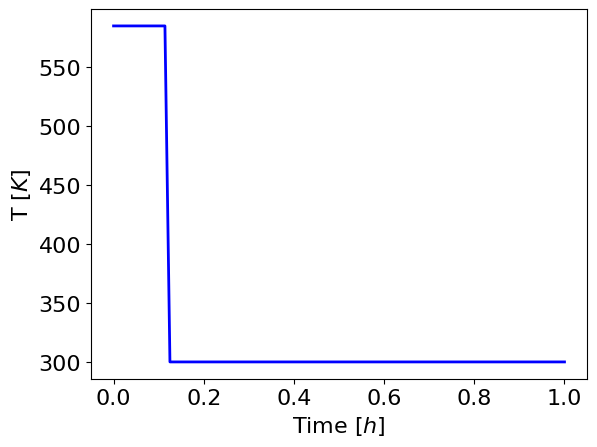

In [13]:
# Printing Results Summary
print('======Results Summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(pyo.value(optimize_result.model.T[i]))

# Plotting    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

These results show us the optimal solution for the results of the design variables.

## Step 7: Method for Exploratory Analysis through Enumeration

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.

### Specify User Inputs

In [14]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## Choose from 'sequential_finite', 'direct_kaug'
# sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# Model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

### Add Prior Information

In [15]:
# Add prior information
prior_all = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

# Printing the shape of the prior information
print(np.shape(prior_all))

# Converts the input of all the prior information into an array
# Prints the shape of the array
prior_pass=np.asarray(prior_all)
print(np.shape(prior_pass))

# Printing results
print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

(4, 4)
(4, 4)
The prior information FIM: [[  22.52943024    1.84034314  -70.23273336  -11.09432962]
 [   1.84034314   18.09848116   -5.73565034 -109.15866135]
 [ -70.23273336   -5.73565034  218.94192843   34.57680848]
 [ -11.09432962 -109.15866135   34.57680848  658.37644634]]
Prior Det: 1.9558434494323278e-08


### MBDoE Analysis

In [16]:
# Creating a doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
                                 dv_pass, # design variable and its control time set
                                 measure_class, # measurement variable and its time set
                                 createmod, # the model we created
                                 prior_FIM=prior_pass, # the FIM of the prior experiments
                                 discretize_model=disc, # the discretized model
                                 args=args_ # argument kaug, define something in your own process model (special requirements)
                                 )

# Grid search for any number of design variables
# Sequentially solves square problems for computing FIM
all_fim = doe_object.run_grid_search(exp1,
                                     design_ranges, # list of design variable values
                                     dv_apply_name, # list of design variable names in design range
                                     dv_apply_time, # list of control time points that are fixed to the design_ranges values
                                     mode=sensi_opt # solver option for sensitivity
                                     )

ERROR:pyomo.core:Unable to clone Pyomo component attribute.
Component 'alge_rule_index' contains an uncopyable field '_init_dimen' (<class 'pyomo.core.base.initializer.ConstantInitializer'>).  Setting field to `None` on new object


### 1D Sensitivity Curve

1D sensitivity curve can be drawn by one design variable and fixing the other design variables.

In [17]:
# Extract information from FIM
test = all_fim.extract_criteria()

## Draw 1D sensitivity curve 

# Fixing CA0 to 5.0
fixed = {"'CA0'": 5.0}

# Draw the curve
all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

## Visualizing Results

Now that our analysis is complete, we can take a further look at our results.

## Step 8: Results through Heatmaps and Sensitivity Curves

First we will look at heatmaps.

A **heatmap** shows the change of the objective function or the experimental information content in the design region.

Heatmaps can be drawn by two design variables while fixing the other design variables.

In [18]:
# An empty dictionary
fixed = {}

# Draw the curve
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

### Interpreting Heatmaps

The horizontal and vertical axes represent the two design variables, while the color of each grid shows the experimental information content. 

## Grid search for 3 design variables

### Generate an Experiment

In [19]:
# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T's are for different time control subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## Choose from 'sequential_finite', 'direct_kaug'
# sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# Model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

### MBDoE Analysis

In [20]:
# Creating a doe_object using DesignOfExperiments
doe_object = DesignOfExperiments(parameter_dict, # dictionary of parameters
                                 dv_pass, # design variable and its control time set
                                 measure_class, # measurement variable and its time set
                                 createmod, # the model we created
                                 prior_FIM=prior_pass, # the FIM of the prior experiments
                                 discretize_model=disc, # the discretized model
                                 args=args_ # argument kaug, define something in your own process model (special requirements)
                                 )
# Grid search for any number of design variables
# Sequentially solves square problems for computing FIM
all_fim = doe_object.run_grid_search(exp1, # generated experiment
                                     design_ranges, # list of design variable values
                                     dv_apply_name, # list of design variable names in design range
                                     dv_apply_time, # list of control time points that are fixed to the design_ranges values
                                     mode=sensi_opt # solver option for sensitivity
                                     )

Now we will look at sensitivity curves.

### Draw 1D Sensitivity Curve

We will start by extracting the FIM information and drawing the 1D sensitivity curve using the FIM criteria.

In [21]:
# Extract information from FIM 
%matplotlib inline
test = all_fim.extract_criteria()

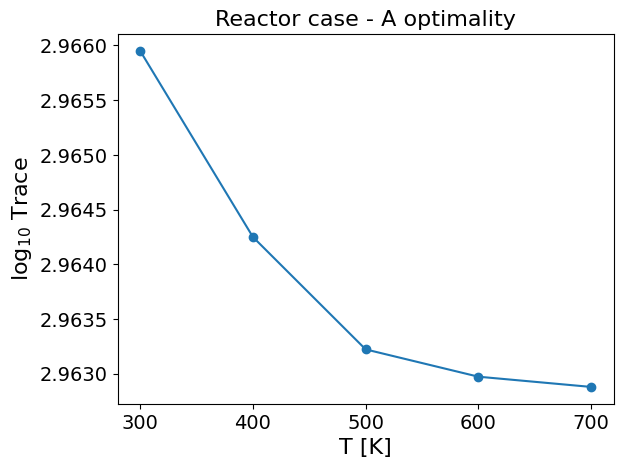

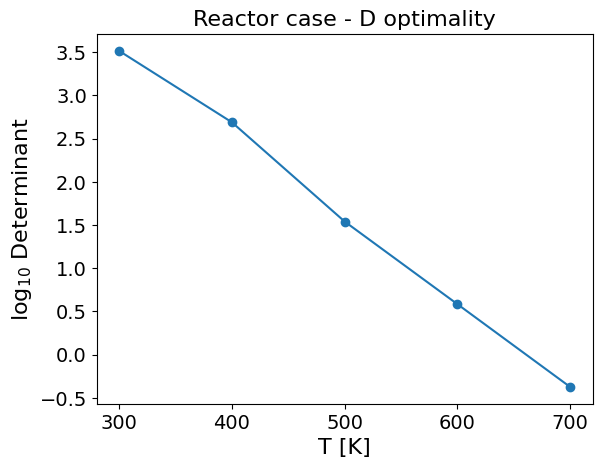

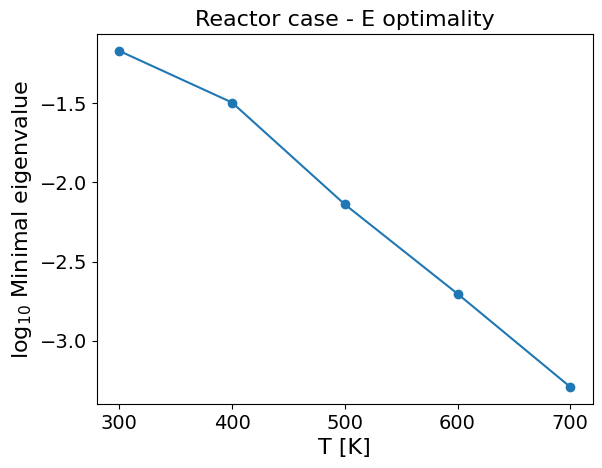

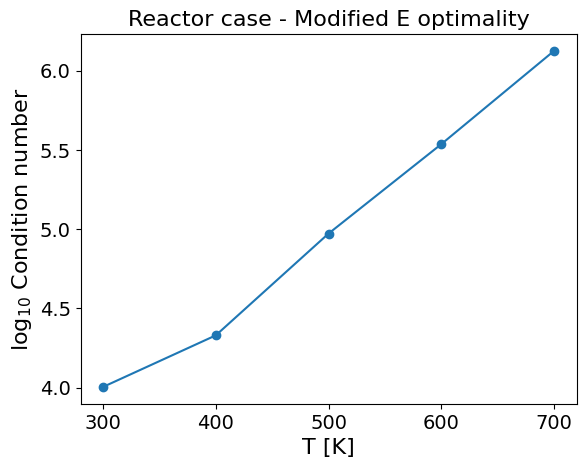

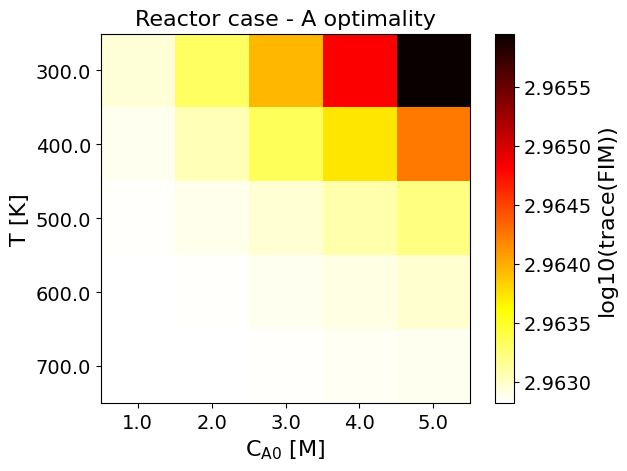

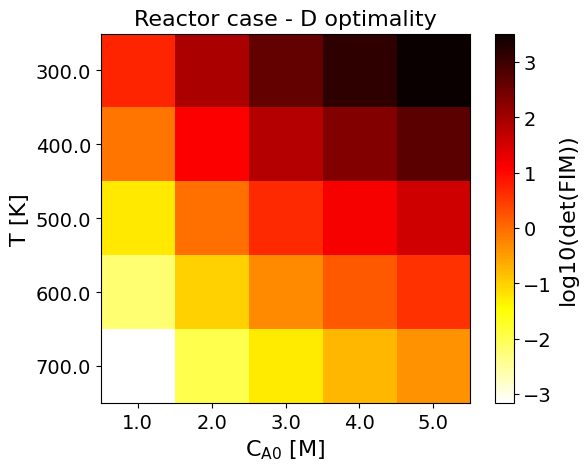

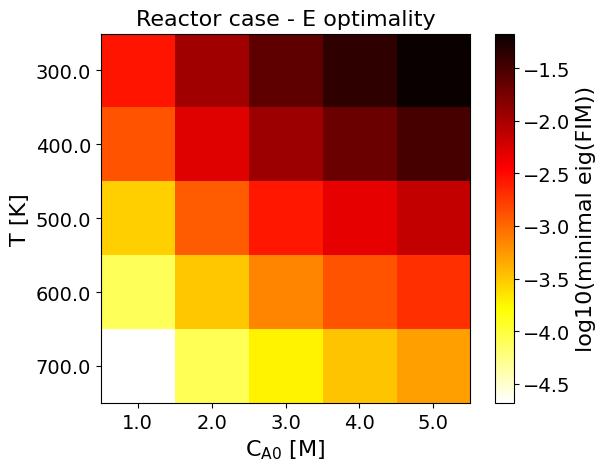

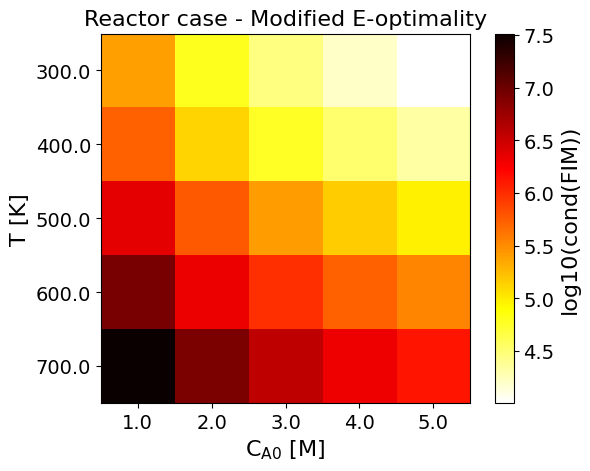

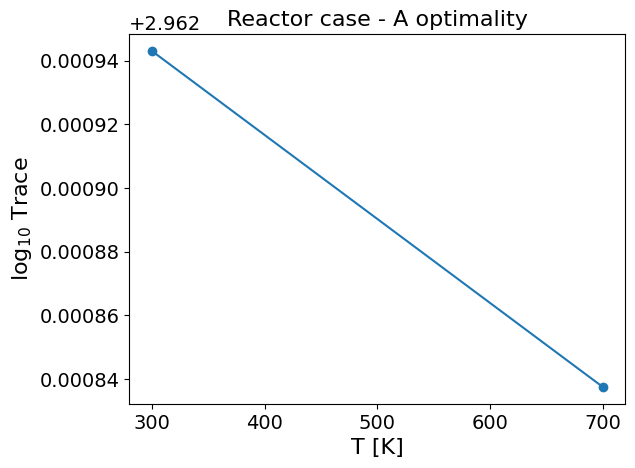

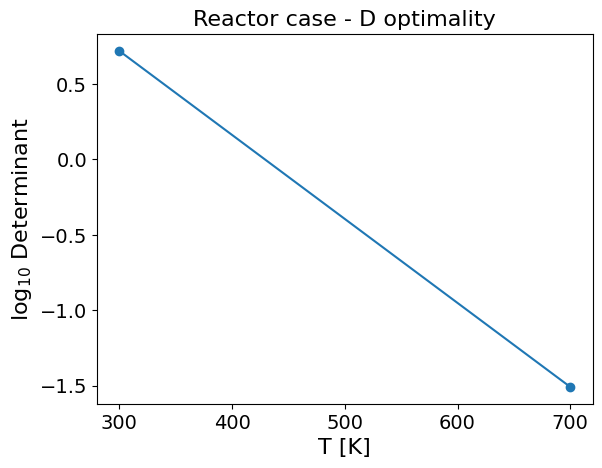

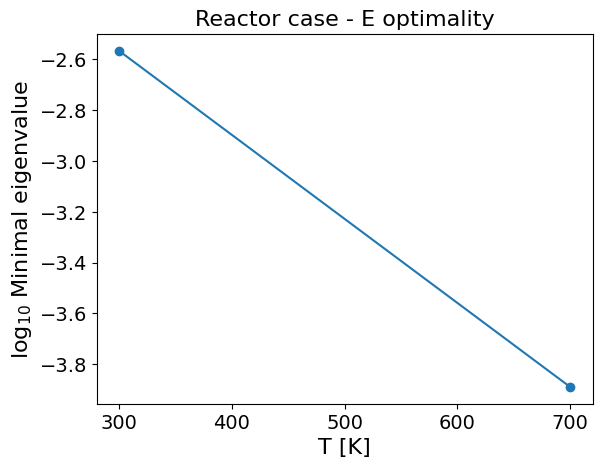

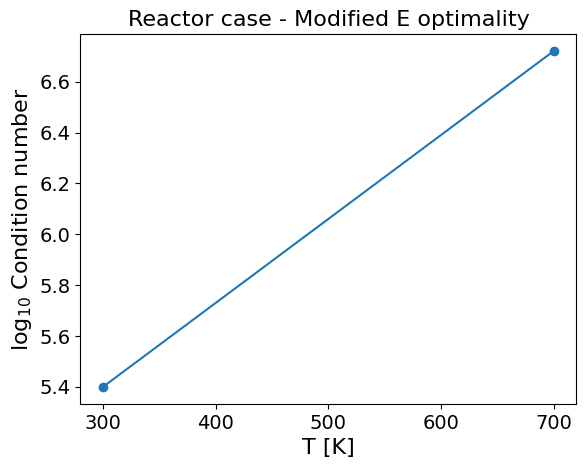

In [22]:
# Draw 1D sensitivity curve 

# Fixing CA0 as 1.0 and T2 as 300
fixed = {"'CA0'": 1.0, "'T2'": 300}

# Draw the curve
all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

As an example, the Figure from the Reactor case - A optimality shows:

The **most** informative region is around $C_{A0}=5.0 \ \text{M},$ $T=300.0 \ \text{K}$. \\
The **least** informative region is around $C_{A0}=1.0 \ \text{M},$ $T=700.0 \ \text{K}$. 

### Draw 2D Sensitivity Curve

Now we will draw the 2D sensitivity curve using the FIM criteria.

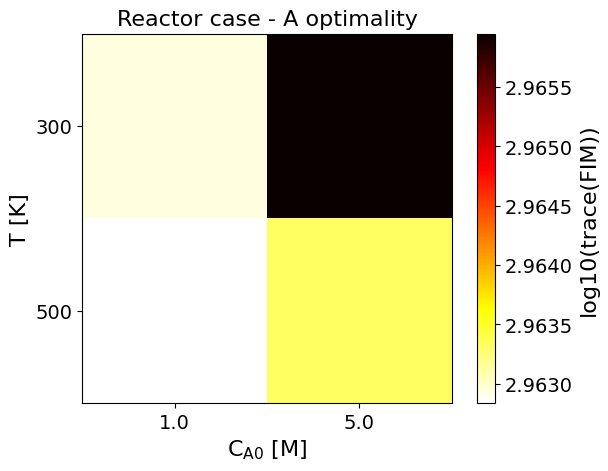

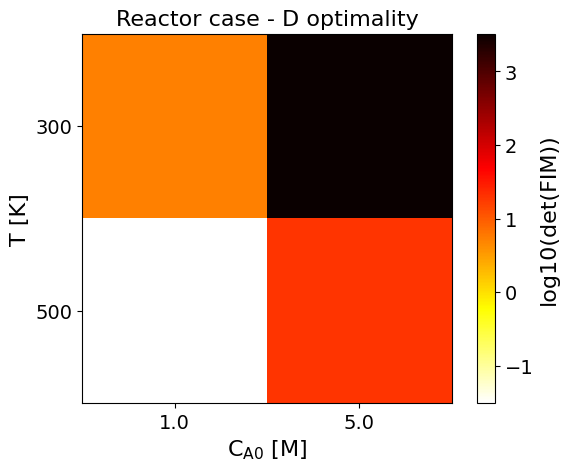

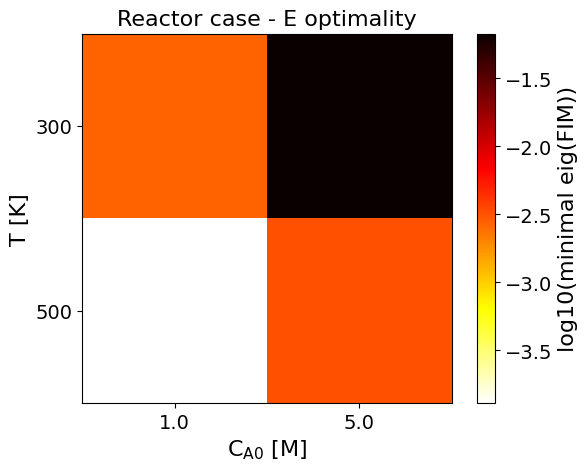

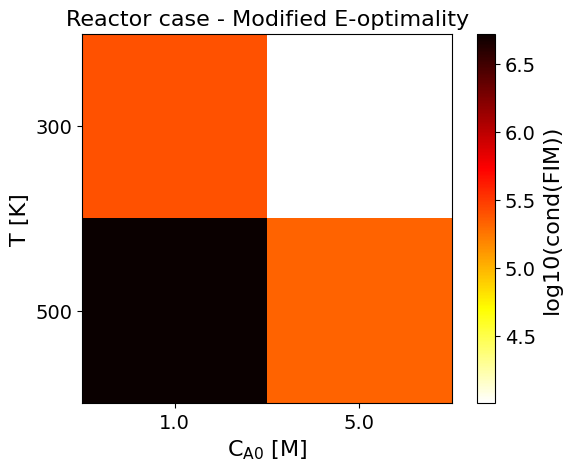

In [23]:
# Drawing 2D sensitivity curve

# Fixing T2 as 300
fixed = {"'T2'": 300}

# Drawing the curve
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

As an example, the Figure from the Reactor case - D optimality shows:

The **most** informative region is around $C_{A0}=5.0 \ \text{M},$ $T=300.0 \ \text{K}$. \\
The **least** informative region is around $C_{A0}=1.0 \ \text{M},$ $T=500.0 \ \text{K}$. 

## Key Takeaways

* MBDoE is helpful for guiding decision-making by maximizing information yield in experimental design.
* FIM allows us to gain information about the data from a mathematical model in an experiment.
* Optimality conditions tells us the most and least informative regions in regards to the measurements in experimental design.
* Heatmaps enable us to visualize the most informative parameters using the optimality conditions.